B455 Project 1
February 23rd, 2023
Sam Johnson

Final Epoch (999) - Training Accuracy: 0.965034965034965, Validation Accuracy: 0.9714285714285714
Final Epoch (999) - Training Accuracy: 0.9366197183098591, Validation Accuracy: 0.8888888888888888
Final Epoch (999) - Training Accuracy: 0.8741258741258742, Validation Accuracy: 0.8571428571428572
Final Epoch (999) - Training Accuracy: 0.9859154929577465, Validation Accuracy: 0.8611111111111112
Final Epoch (999) - Training Accuracy: 0.971830985915493, Validation Accuracy: 0.9444444444444444


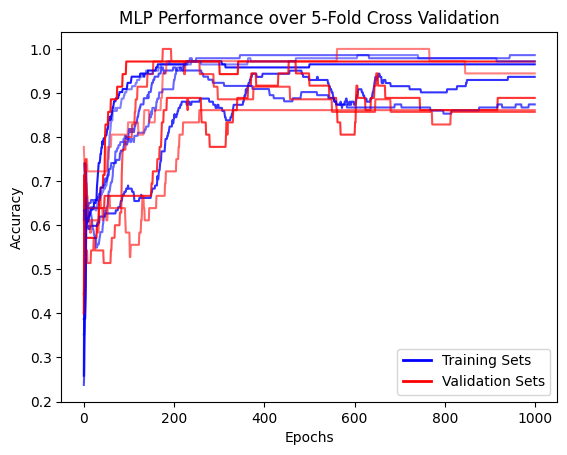

Average Prediction Accuracies across 5 CV Folds:
Baseline Predictor: 0.3423809523809524
My MLP: 0.9046031746031746


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random as rn
import os


#------------------------------------------------------------------------
# DATA PREPROCESSING
#------------------------------------------------------------------------
def load_data(datapath):
    csv_path = os.path.abspath(datapath)
    return pd.read_csv(csv_path, header=None)

def data_shuffle(dataset):
    dataset = dataset.sample(frac=1).reset_index(drop=True)
    return dataset
    
def cross_val_folds(dataset, fold, n_folds):
    n = len(dataset)
    return dataset[n*(fold-1)//n_folds : n*fold//n_folds]

def split_labels(dataset):
    y = dataset.iloc[:,0]
    x = dataset.drop(0, axis=1)
    return x, y

def standardize(df):
    df_stand = df.copy()
    for column in df_stand.columns:
        df_stand[column] = (df_stand[column] - df_stand[column].mean()) / df_stand[column].std()    
    return df_stand

def onehotencode(series):
    vector = np.array(series)
    encoded = np.zeros(shape=(len(vector),3))
    for i in range(len(vector)):
        if vector[i] == 1:
            encoded[i] = np.array([1,0,0])
        if vector[i] == 2:
            encoded[i] = np.array([0,1,0])
        if vector[i] == 3:
            encoded[i] = np.array([0,0,1])
    return encoded


#---------------------------------------------------------------------------------------
# MLP
#---------------------------------------------------------------------------------------

class MLP:

    def __init__(self, n_hidden, n_input_feat, n_classes, learning_rate, epochs):
        self.n_hidden = n_hidden #4
        self.n_input = n_input_feat #13
        self.n_output = n_classes #3
        self.lr = learning_rate #0.01
        self.epochs = epochs #40

        self.v = np.random.uniform(size=((self.n_input+1)*self.n_hidden,1))
        self.w = np.random.uniform(size=((self.n_hidden+1)*self.n_output,1))


    def hidden_layer(self, x, v):
        a = np.zeros(shape=(self.n_hidden,1))
        for node in range(self.n_hidden): #0,1,2,3
            a_x = np.zeros(shape=(self.n_input+1,1)) 
            for index in range(len(v)): #0,1,2,3,...,54,55
                if index % self.n_hidden == node:
                    a_x[index//self.n_hidden] = v[index]
            a[node] = np.dot(a_x.T,x)
        return a
        
    def sigmoid(self, vector):
        for entry in range(len(vector)):
            vector[entry] = (lambda z: 1/(1 + np.exp(-z)))(vector[entry])
        return vector
    
    def output_layer(self, a, w):
        y = np.zeros(shape=(self.n_output,1))
        for node in range(self.n_output): #0,1,2
            y_a = np.zeros(shape=(self.n_hidden+1,1)) 
            for index in range(len(w)): #0,1,2,3,...,14
                if index % self.n_output == node:
                    y_a[index//self.n_output] = w[index]
            y[node] = np.dot(y_a.T,a)
        return y
        
    def softmax(self, vector):
        e_vector = np.exp(vector)
        sum = np.sum(e_vector)
        return e_vector*(1/sum)
        
    def forward(self, input):
        input = np.array(input).reshape(self.n_input,1)
        x = np.append(np.array([[1]]), input, axis=0)
        a = self.sigmoid(self.hidden_layer(x, self.v))
        a = np.array(a).reshape(self.n_hidden,1)
        a = np.append(np.array([[1]]), a, axis=0)
        a1 = np.ndarray.copy(a)
        y = self.softmax(self.output_layer(a1, self.w))
        return (x,a,y)
     
    def delta_output(self, prediction, label):
        return (prediction-label)*prediction*(1-prediction)
    
    def delta_hidden(self, a, delt_out):
        delt_hidd = np.zeros(shape=np.shape(a))
        for j in range(len(delt_hidd)):
            loc_sum = 0
            for index in range(len(self.w)):
                which_a = index // self.n_output
                which_out_node = index % self.n_output
                if which_a == j:
                    loc_sum += delt_out[which_out_node]*self.w[index]
            delt_hidd[j] = a[j]*(1-a[j])*loc_sum
        return delt_hidd

    def predict(self, attributes):
        prediction = np.zeros(shape=(len(attributes.index),1))
        for i in range(len(attributes.index)):
            x, a, y = self.forward(attributes.iloc[i])
            for j in range(len(y)):
                if y[j] == np.amax(y):
                    prediction[i] = j+1
        return prediction


    def fit(self, train_attrib, train_labels, val_attrib, val_labels):

        train_results = []
        val_results = []

        for epoch in range(self.epochs):

            train_missed, val_missed = 0., 0.

            for i in range(len(train_attrib)):

                tr_label =  np.array(train_labels[i]).reshape(self.n_output,1)

                #forward pass for training data
                x, a, y  = self.forward(train_attrib.iloc[i])

                #updating error term
                tr_pred_one_hot = np.zeros(shape=np.shape(y))
                for i in range(len(y)):
                    if y[i] == np.amax(y):
                        tr_pred_one_hot[i] = 1
                if not np.array_equal(tr_pred_one_hot, tr_label):
                    train_missed += 1

                #calculating gradients
                delt_out = self.delta_output(y,tr_label) #tensor of shape len(self.n_output)
                delt_hidd = self.delta_hidden(a, delt_out) #tensor of shape len(self.n_hidden)

                #calculating second layer weights updates
                new_w = np.zeros(shape=np.shape(self.w))
                for index in range(len(self.w)):
                    which_a = index // self.n_output
                    which_out_node = index % self.n_output
                    new_w[index] = self.w[index] - self.lr*delt_out[which_out_node]*a[which_a]
                
                #calculating first layer weights updates
                new_v = np.zeros(shape=np.shape(self.v))
                for index in range(len(self.v)):
                    which_in_node = index // self.n_hidden
                    which_hidd_node = index % self.n_hidden
                    new_v[index] = self.v[index] - self.lr*delt_hidd[which_hidd_node]*x[which_in_node]

                #updating weights   
                self.w = new_w
                self.v = new_v
            
            #forward pass for validation set
            for j in range(len(val_attrib)):
                val_label =  np.array(val_labels[j]).reshape(self.n_output,1)
                val_x, val_a, val_y  = self.forward(val_attrib.iloc[j])

            #updating error term for validation set
                val_pred_one_hot = np.zeros(shape=np.shape(val_y))
                for i in range(len(val_y)):
                    if val_y[i] == np.amax(val_y):
                        val_pred_one_hot[i] = 1
                if not np.array_equal(val_pred_one_hot, val_label):
                    val_missed += 1

            #calculating accuracy  
            train_acc = 1 - train_missed/len(train_attrib)
            val_acc = 1 - val_missed/len(val_attrib)
            train_results.append(train_acc)
            val_results.append(val_acc)

            if epoch == self.epochs - 1:
                print(f'Final Epoch ({epoch}) - Training Accuracy: {train_acc}, Validation Accuracy: {val_acc}')
        
        return train_results, val_results


#-------------------------------------------------------------------------------------------------------------------
# RUNNING EXPERIMENT
#-------------------------------------------------------------------------------------------------------------------

def dummy_predictor(test_set_labels):
    errors = 0
    for i in test_set_labels:
        if i != rn.randint(1,3):
            errors += 1
    return 1 - errors/len(test_set_labels)


def main(datapath):
    #loading and shuffling dataset
    dataset = data_shuffle(load_data(datapath))
    
    prediction_accuracy = []
    dummy_accuracy = []

    #five CV Runs
    for fold in range(1,6):

        #creating validation and test sets
        val_set = cross_val_folds(dataset, fold, 5)
        train_set = dataset.drop(val_set.index)

        #splitting attributes from labels
        train_x, train_y = split_labels(train_set)
        val_x, val_y = split_labels(val_set)

        #one-hot-encoding labels
        train_y_hot = onehotencode(train_y)
        val_y_hot = onehotencode(val_y)

        # standardizing attributes
        train_x_stand = standardize(train_x)
        val_x_stand = standardize(val_x)

        #initializing MLP to be trained 
        epochs = 1000
        lr = 0.01
        myMLP = MLP(4,13,3,lr,epochs)

        #training and predicting with the MLP
        train_results, val_results = myMLP.fit(train_x_stand, train_y_hot, val_x_stand, val_y_hot)

        #plotting training process
        plt.plot(range(epochs), train_results, color='blue', alpha=1-fold*.1)
        plt.plot(range(epochs), val_results, color='red', alpha=1-fold*.1)

        #collecting prediction accuracy for this round of CV
        prediction_accuracy.append(val_results[-1])

        #predicting with dummy predictor and recording accuracy
        dummy_accuracy.append(dummy_predictor(val_y))


    # plotting training and validation accuracy 
    custom_lines_for_legend = [Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='red', lw=2)]
    plt.legend(custom_lines_for_legend, ['Training Sets', 'Validation Sets'])
    plt.title('MLP Performance over 5-Fold Cross Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    # comparing accuracy of dummy model to accuracy of trained MLP on 5-fold CV
    final_pred_acc = sum(prediction_accuracy)/len(prediction_accuracy)
    final_dummy_acc = sum(dummy_accuracy)/len(dummy_accuracy)

    print(f'Average Prediction Accuracies across 5 CV Folds:\nBaseline Predictor: {final_dummy_acc}\nMy MLP: {final_pred_acc}')
    pass


main('wine.data')


The Wine Dataset is a record of the chemical analyses of wine grow in Italy. I have attempted to build a machine learning system, from which a model could be produced that can categorize wines based on their chemical profiles with high accuracy. 

The Wine Dataset is a collection of 178 instances that store attributes of the wine such as alcohol content, malic acid content, ash content, etc. The dataset records 13 of these attributes, along with a class label for the wine of 1, 2, or 3. To prepare the dataset for modeling, I began with several preprocessing steps. First, I shuffled the instances of the data, because the instances were arranged based on their class label. This is necessary to generate training and testing sets from the raw dataset that represent the dataset as a whole. I then split the data into 5 approxiamately equal size partitions to prepare for cross-validation. Cross-validation (CV) is the process of partitioning a dataset into $k$ folds, and then training on $k-1$ folds and testing the model on the remaining fold. This is repeated $k$ times, with each fold acting as the test set exactly once. I performed 5-fold CV

In the future, I will consider experiments where I vary the number of hidden layers, increase the number of hidden layer neurons, and decrease the amount of epochs. 

References: 

[1] Slides from Haixu Tang: https://iu.instructure.com/courses/2117762/pages/module-5-multi-layer-perceptron-mlp?module_item_id=28540669

[2] NumPy User Guide: https://numpy.org/doc/stable/user/

[3] pandas User Guide: https://pandas.pydata.org/docs/user_guide/index.html

[4] matplotlib User Guide: https://matplotlib.org/stable/users/index.html

[5] MXNet's Python Tutorial for training a neural netowrk: https://mxnet.apache.org/versions/1.7/api/python/docs/tutorials/getting-started/crash-course/4-train.html

[6] Vitor Gama Lemos - "Multilayer Perceptron from scratch": https://www.kaggle.com/code/vitorgamalemos/multilayer-perceptron-from-scratch

[7] Michael Nelson - "Pandas: How can I do cross validation without using scikit?": https://stackoverflow.com/questions/43442072/pandas-how-can-i-do-cross-validation-without-using-scikit